# Funtional Transformation Method Utilities

This notebook contains a set of utility functions for the functional transformation method.

In [ ]:
# | default_exp ftm

In [ ]:
# | exporti

from dataclasses import asdict, dataclass

import jax
import numpy as np
from jax import numpy as jnp
from opt_einsum import contract as einsum
from scipy.integrate import simpson, trapezoid
from scipy.signal import cont2discrete
from scipy.special import jn_zeros, jv
from tabulate import tabulate

In [ ]:
# | hide

import matplotlib.pyplot as plt
from IPython.display import Audio

In [ ]:
# | hide
# This is neccessary to pass the tests
jax.config.update("jax_enable_x64", True)

In [ ]:
# | export
# | hide


@dataclass
class PhysicalParameters:
    def asdict(self):
        return asdict(self)

    def tabulate(self) -> str:
        param_symbols: dict[str, str] = {
            "A": "$A$",
            "I": "$I$",
            "rho": "$\\rho$",
            "E": "$E$",
            "d1": "$d_1$",
            "d3": "$d_3$",
            "Ts0": "$T_{s0}$",
            "length": "$\\ell$",
            "h": "$h$",
            "l1": "$l_1$",
            "l2": "$l_2$",
            "nu": "$\\nu$",
            "d0": "$d_0$",
            "d2": "$d_2$",
            "Tm": "$T_m$",
            "f_1": "$f_1$",
            "r0": "$r_0$",
            "f0": "$f_0$",
        }

        param_units: dict[str, str] = {
            "A": "$m^2$",
            "I": "$m^4$",
            "rho": "$kg/m^3$",
            "E": "$Pa$",
            "d1": "$kg/(ms)$",
            "d3": "$kg\\cdot m/s$",
            "Ts0": "$N$",
            "length": "$m$",
            "h": "$m$",
            "l1": "$m$",
            "l2": "$m$",
            "nu": "dimensionless",
            "d0": "$kg/(m^2 s)$",
            "d2": "$kg/s$",
            "Tm": "$N/m$",
            "f_1": "$Hz$",
            "r0": "$m$",
            "f0": "$Hz$",
        }

        table_data = []

        for field_name, field_value in self.asdict().items():
            if field_name in param_symbols:
                symbol = param_symbols[field_name]
                unit = param_units.get(field_name, "")
                table_data.append([symbol, field_value, unit])

        return tabulate(
            table_data,
            headers=["Parameter", "Value", "Units"],
            tablefmt="github",
        )

In [ ]:
# | export


@dataclass
class StringParameters(PhysicalParameters):
    """
    Dataclass to store the parameters of the string.
    """

    # fmt: off
    A: float = 0.5188e-6        # m**2    Cross section area
    I: float = 0.141e-12        # m**4    Moment of intertia
    rho: float = 1140           # kg/m**3 Density
    E: int = 5.4e9              # Pa      Young's modulus
    d1: float= 8e-5             # kg/(ms) Frequency independent loss
    d3: float = 1.4e-5          # kg m/s  Frequency dependent loss
    Ts0: float = 60.97          # N       Tension
    length: float = 0.65        # m       Length of the string
    # fmt: on

    @staticmethod
    def piano_string():
        """
        From Table 5.1 of Digital Sound Synthesis using the FTM
        """
        return StringParameters(
            A=1.54e-6,
            I=4.12e-12,
            rho=57.0e3,
            E=19.5e9,
            d1=3e-3,
            d3=2e-5,
            Ts0=2104,
            length=1.08,
        )

    @staticmethod
    def bass_string():
        """
        From Table 5.1 of Digital Sound Synthesis using the FTM
        """
        return StringParameters(
            A=2.4e-6,
            I=0.916e-12,
            rho=6300,
            E=5e9,
            d1=6e-3,
            d3=1e-3,
            Ts0=114,
            length=1.05,
        )

    @staticmethod
    def guitar_string_D():
        """
        From Table 8.2 of Simulation of Distributed Parameter Systems by Transfer Function Models
        """
        return StringParameters(
            A=7.96e-7,
            I=0.171e-12,
            rho=1140,
            E=5.4e9,
            d1=8e-5,
            d3=1.4e-5,
            Ts0=13.35,
            length=0.65,
        )

    @staticmethod
    def guitar_string_B_schafer():
        """
        From A String In a Room: Mixed-Dimensional Transfer Function Models for Sound Synthesis
        """
        return StringParameters(
            A=0.5e-6,
            I=0.17e-12,
            rho=1140,
            E=5.4e9,
            d1=8e-5,
            d3=1.4e-5,
            Ts0=60.97,
            length=0.65,
        )

    @property
    def density(self):
        """
        Area density of the string
        """
        return self.rho * self.A

    @property
    def bending_stiffness(self):
        return self.E * self.I

In [ ]:
# | export


@dataclass
class PlateParameters(PhysicalParameters):
    """
    Physical parameters for a rectangular plate simulation.

    Properties
    ----------
    density : float
        Mass per unit area (kg/m²)
    D : float
        Flexural rigidity (N·m)
    """

    # fmt: off
    h: float = 5e-4             # m           Thickness
    l1: float = 0.2             # m           Width
    l2: float = 0.3             # m           Height
    rho: float = 7.8e3          # (kg/m³)     Density
    E: int = 2e12               # Pa          Young's modulus
    nu: float = 0.3             #             Poisson's ratio
    d1: float= 4.2e-2           #             Frequency independent loss
    d3: float = 2.3e-3          #             Frequency dependent loss
    Ts0: float = 100            # N/m         Surface Tension
    # fmt: on

    @property
    def density(self):
        return self.rho * self.h

    @property
    def bending_stiffness(self):
        return self.E * self.h**3 / (12 * (1 - self.nu**2))

In [ ]:
# | export


@dataclass
class CircularDrumHeadParameters(PhysicalParameters):
    """
    Kettle drum head, from Digital sound synthesis of string instruments with
    the functional transformation method Table 5.2.
    """

    # fmt: off
    h: float = 1.9e-4           # m           Thickness
    r0: float = 0.328           # m           Radius
    I: float = 0.57e-12         # m**4        Moment of intertia
    rho: float = 1.38e3         # kg/m**3     Density
    E: int = 3.5e9              # Pa          Young's modulus
    nu: float = 0.35            #             Poisson's ratio
    d1: float= 0.14             # kg/(m**2 s) Frequency independent loss
    d3: float = 0.32            # kg/s        Frequency dependent loss
    Ts0: float = 3990           # N/m         Surface Tension
    f0: float = 143.95          # Hz          Fundamental frequency
    # fmt: on

    @property
    def density(self):
        return self.rho * self.h

    @property
    def bending_stiffness(self):
        return self.E * self.h**3 / (12 * (1 - self.nu**2))

    @staticmethod
    def avanzini():
        """
        From Section VI of "A Modular Physically Based Approach to
        the Sound Synthesis of Membrane Percussion Instruments"
        """
        return CircularDrumHeadParameters(
            h=2e-4,
            r0=0.20,
            rho=1350.0,
            E=3.5e9,
            nu=0.2,
            d1=1.25,
            d3=5e-4,
            Ts0=1500,
        )

In [ ]:
# | export


def string_eigenvalues(n_modes: int, length: float):
    r"""
    Compute the eigenvalues of a string with fixed ends.

    The eigenvalues are given by:

    $$\lambda_\mu = \left(\frac{\mu \pi}{L}\right)^2$$

    where $\mu$ is the mode number and $L$ is the length of the string.

    Parameters
    ----------
    n_modes : int
        Number of modes to compute
    length : float
        Length of the string

    Returns
    -------
    jnp.ndarray
        Array of eigenvalues with shape (n_modes,)
    """
    mu = jnp.arange(1, n_modes + 1)
    return (mu * jnp.pi / length) ** 2


def string_eigenfunctions(
    wavenumbers: np.ndarray,
    grid: np.ndarray,
) -> np.ndarray:
    r"""
    Compute the modes of the string.
    The modes of the string are given by:

    $$
    K = \sin(\pi x k)
    $$

    where $k$ is the wavenumber and $x$ is the grid positions.

    Parameters
    ----------
    wavenumbers : np.ndarray
        The wavenumbers of the string.
    grid : np.ndarray
        The grid positions of the string where to compute the modes.

    Returns
    -------
    np.ndarray
        The modes of the string at the given grid positions.
    """
    return np.sin(np.outer(wavenumbers, grid))

In [ ]:
# | export


def plate_wavenumbers(
    n_max_modes_x: int,
    n_max_modes_y: int,
    l1: float,
    l2: float,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    r"""
    Compute the wavenumbers of a rectangular plate with clamped edges.

    The wavenumbers are given by:

    $$k_x = \frac{\mu \pi}{L_1}, \quad k_y = \frac{\nu \pi}{L_2}$$

    where $\mu$ and $\nu$ are the mode numbers, and $L_1$ and $L_2$ are the plate dimensions.

    Parameters
    ----------
    n_max_modes_x : int
        Number of modes in x direction
    n_max_modes_y : int
        Number of modes in y direction
    l1 : float
        Width of the plate
    l2 : float
        Height of the plate

    Returns
    -------
    tuple[jnp.ndarray, jnp.ndarray]
        Wavenumbers in x and y directions with shapes (n_max_modes_x,) and (n_max_modes_y,)
    """

    mu_x = jnp.arange(1, n_max_modes_x + 1)
    mu_y = jnp.arange(1, n_max_modes_y + 1)
    wavenumbers_x = mu_x * jnp.pi / l1
    wavenumbers_y = mu_y * jnp.pi / l2
    return wavenumbers_x, wavenumbers_y


def plate_eigenvalues(
    wavenumbers_x: np.ndarray,  # (n_max_modes_x,)
    wavenumbers_y: np.ndarray,  # (n_max_modes_y,)
):
    r"""

    Compute the eigenvalues of the plate.
    The eigenvalues of the plate are given by:

    \begin{equation}
    \lambda_{\mu, \nu}
    = \left(\frac{\mu \pi}{L_1}\right)^2 + \left(\frac{\nu \pi}{L_2}\right)^2
    \end{equation}

    where $\mu$ and $\nu$ are the mode numbers
    and $L_1$ and $L_2$ are the width and height of the plate.

    Parameters
    ----------
    wavenumbers_x: np.ndarray
        The wavenumbers in the x direction.
    wavenumbers_y: np.ndarray
        The wavenumbers in the y direction

    Returns
    -------
    np.ndarray
        The eigenvalues
    """
    wn_x, wn_y = jnp.meshgrid(wavenumbers_x, wavenumbers_y)

    return wn_x**2 + wn_y**2


def plate_eigenfunctions(
    wavenumbers_x: np.ndarray,  # (n_max_modes_x,)
    wavenumbers_y: np.ndarray,  # (n_max_modes_y,)
    x: np.ndarray,  # (n_gridpoints_x,)
    y: np.ndarray,  # (n_gridpoints_y,)
) -> np.ndarray:
    r"""
    Compute the modes of the plate.
    The modes of the plate are given by:

    $$
    K = \sin(\pi x k) \sin(\pi y k)
    $$

    where $k$ is the wavenumber and $x$ and $y$ are the grid positions.
    """

    # Compute the sine values using broadcasting
    sin_wx_grid_x = np.sin(wavenumbers_x[:, None] * x[None, :])
    sin_wy_grid_y = np.sin(wavenumbers_y[:, None] * y[None, :])

    # Use einsum to compute the outer product and obtain the modes
    return einsum("m x, n y -> m n x y", sin_wx_grid_x, sin_wy_grid_y)

In [ ]:
# | export


def drumhead_wavenumbers(
    n_max_modes: int,
    m_max_modes: int,
    radius: float,
) -> np.ndarray:
    """
    Compute the wavenumbers of the drumhead.

    Parameters:
    ----------
    n_max_modes: int
        The number of angular modes.
    m_max_modes: int
        The number of radial modes.
    radius: float
        The radius of the drumhead.

    Returns:
    -------
    wavenumbers: np.ndarray
        The wavenumbers for the drumhead.
    """
    # Bessel function roots for different orders (n) and radial modes (m)
    wavenumbers = np.zeros((n_max_modes, m_max_modes))
    for n in range(n_max_modes):
        bessel_roots = jn_zeros(n, m_max_modes)
        wavenumbers[n, :] = bessel_roots / radius
    return wavenumbers


def drumhead_eigenvalues(
    wavenumbers: np.ndarray,  # (n_max_modes, m_max_modes)
):
    """
    Compute the eigenvalues of the drumhead.
    The eigenvalues of the drumhead are given by the square of the wavenumbers.

    Parameters:
    ----------
    wavenumbers: np.ndarray
        The wavenumbers for the drumhead.
    squared: bool
        If True, return the squared eigenvalues.

    Returns:
    -------
    eigenvalues: np.ndarray
        The eigenvalues of the drumhead.
    """
    return wavenumbers**2


def drumhead_eigenfunctions(
    wavenumbers: np.ndarray,  # (n_max_modes, m_max_modes)
    r: np.ndarray,  # (n_gridpoints_r)
    theta: np.ndarray,  # (n_gridpoints_theta)
) -> np.ndarray:
    """
    Compute the modes of the drumhead.
    The modes of the drumhead are given by the Bessel function times the sine/cosine of the angle.

    Parameters:
    ----------
    wavenumbers: np.ndarray
        The wavenumbers for the drumhead.
    r: np.ndarray
        Radial grid points.
    theta: np.ndarray
        Angular grid points.

    Returns:
    -------
    modes: np.ndarray
        The eigenfunctions for the drumhead.
    """
    n_max_modes, m_max_modes = wavenumbers.shape
    n_gridpoints_r = len(r)
    n_gridpoints_theta = len(theta)

    # Initialize the modes array
    modes = np.zeros((n_max_modes, m_max_modes, n_gridpoints_r, n_gridpoints_theta))
    inverse_modes = np.zeros_like(modes)

    squared_norms = np.zeros((n_max_modes, m_max_modes))

    r_grid, theta_grid = np.meshgrid(r, theta, indexing="ij")

    # Compute the modes
    for n in range(n_max_modes):
        for m in range(m_max_modes):
            modes[n, m] = np.cos(n * theta_grid) * jv(n, wavenumbers[n, m] * r_grid)

            # calculate the squared norm
            integrand = modes[n, m] ** 2 * r_grid
            integral_theta = simpson(integrand, x=theta, axis=1)
            squared_norms[n, m] = simpson(integral_theta, x=r)

            # get the normalised modes
            inverse_modes[n, m] = modes[n, m] / squared_norms[n, m]

    return modes, inverse_modes, squared_norms

In [ ]:
# | export


def dblintegral(integrand, x, y, method="simpson"):
    """
    Compute the double integral of a function K over the domain x and y.
    """

    if method == "simpson":
        integral_y = simpson(integrand, x=y, axis=1)
        return simpson(integral_y, x=x)
    elif method == "trapezoid":
        integral_y = trapezoid(integrand, x=y, axis=1)
        return trapezoid(integral_y, x=x)
    else:
        raise ValueError("Method not supported")

In [ ]:
# Example usage
n_max_modes = 25
m_max_modes = 25
radius = 1.0
n_gridpoints_r = 100
n_gridpoints_theta = 100

wavenumbers = drumhead_wavenumbers(n_max_modes, m_max_modes, radius)
eigenvalues = drumhead_eigenvalues(wavenumbers)
r = np.linspace(0, radius, n_gridpoints_r)
theta = np.linspace(0, 2 * np.pi, n_gridpoints_theta)
K_fwd, K_inv, K_N = drumhead_eigenfunctions(wavenumbers, r, theta)

assert K_inv.shape == (
    n_max_modes,
    m_max_modes,
    n_gridpoints_r,
    n_gridpoints_theta,
)

assert K_fwd.shape == (
    n_max_modes,
    m_max_modes,
    n_gridpoints_r,
    n_gridpoints_theta,
)

$$
K_{n,m}(r, \varphi) = \cos (n \varphi) J_n\left(\mu_{n, m} \frac{r}{R}\right)
$$

where $J_n$ is the Bessel function of the first kind of order $n$, and $\mu_{n, m}$ is the $m$-th root of the $n$-th order Bessel function of the first kind.

In [ ]:
# | hide
n_max_modes_x = 6
n_max_modes_y = 6
n_gridpoints_x = 20
n_gridpoints_y = 20
length_x = 1.08
length_y = 1.08
grid_x = np.linspace(0, length_x, n_gridpoints_x)
grid_y = np.linspace(0, length_y, n_gridpoints_y)

# slow version
# Define the range for n and m
n_values = np.arange(1, n_max_modes_x + 1)
m_values = np.arange(1, n_max_modes_y + 1)

# Define the range for x and y
x_values = np.linspace(0, length_x, n_gridpoints_x)
y_values = np.linspace(0, length_y, n_gridpoints_y)

# Initialize the 4D array to store the results
K = np.zeros((len(n_values), len(m_values), len(x_values), len(y_values)))
Lambda = np.zeros((len(n_values), len(m_values)))
# Compute the values
for i, n in enumerate(n_values):
    for j, m in enumerate(m_values):
        Lambda[i, j] = np.pi**2 * ((n / length_x) ** 2 + (m / length_y) ** 2)
        for k, x in enumerate(x_values):
            for l, y in enumerate(y_values):
                K[i, j, k, l] = np.sin(n * np.pi * x / length_x) * np.sin(
                    m * np.pi * y / length_y
                )

In [ ]:
# | test

wnx, wny = plate_wavenumbers(n_max_modes_x, n_max_modes_y, length_x, length_y)
assert np.allclose(plate_eigenfunctions(wnx, wny, grid_x, grid_y), K)
assert np.allclose(plate_eigenvalues(wnx, wny), Lambda)

In [ ]:
# | export


def forward_STL(
    K: np.ndarray,  # (n_modes, n_gridpoints)
    u: np.ndarray,  # (n_gridpoints, n_samples) or (n_gridpoints,)
    dx: float,  # grid spacing
) -> np.ndarray:
    """
    Compute the forward STL transform. The integration is done using the trapezoidal rule.

    Parameters
    ----------
    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u: np.ndarray
        The input signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    dx: float
        The grid spacing of the sampled string.

    Returns
    -------
    np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    """
    if u.ndim == 1:
        u = u[:, None]
    transformed_signal = dx * einsum("m n, n s -> m s", K, u)
    return transformed_signal if u.shape[1] > 1 else transformed_signal[:, 0]


def inverse_STL(
    K: np.ndarray,  # (n_modes, n_gridpoints)
    u_bar: np.ndarray,  # (n_modes, n_samples) or (n_modes,)
    length: float,  # length of the string
) -> np.ndarray:
    """
    Compute the inverse STL transform using the formula of Rabenstein et al. (2000).

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u_bar: np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    length: float
        The length of the string.

    Returns:
    --------
    np.ndarray
        The reconstructed signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    """
    if u_bar.ndim == 1:
        u_bar = u_bar[:, None]  # Convert to (n_modes, 1) if input is (n_modes,)

    N = length / 2.0
    reconstructed_signal = einsum("m n, m s -> n s", K, u_bar) / N
    return reconstructed_signal if u_bar.shape[1] > 1 else reconstructed_signal[:, 0]

In [ ]:
# | export


def forward_STL_2d(
    K: np.ndarray,  # (n_modes_x, n_modes_y, n_gridpoints_x, n_gridpoints_y)
    u: np.ndarray,  # (n_gridpoints_x, n_gridpoints_y, n_samples) or (n_gridpoints_x, n_gridpoints_y)
    x: float,  # grid spacing
    y: float,  # grid spacing
    use_simpson: bool = False,
) -> np.ndarray:
    """
    Compute the forward STL transform. The integration is done using the trapezoidal rule.

    Parameters
    ----------
    K : np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u : np.ndarray
        The input signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    dx : float
        The grid spacing of the sampled string.

    Returns
    -------
    np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    """
    if u.ndim == 2:
        u = u[..., None]

    if use_simpson:
        n_modes_x, n_modes_y, _, _ = K.shape
        _, _, n_samples = u.shape

        # print(u.shape)
        transformed_signal = np.zeros((n_modes_x, n_modes_y, n_samples))

        for mode_x in range(n_modes_x):
            for mode_y in range(n_modes_y):
                for sample in range(n_samples):
                    # Perform 2D Simpson's integration
                    uu = K[mode_x, mode_y] * u[:, :, sample]

                    # integral_x = simpson([simpson(uu_y, dx=dy) for uu_y in uu], dx=dx)
                    transformed_signal[mode_x, mode_y, sample] = dblintegral(
                        uu,
                        x,
                        y,
                        method="simpson",
                    )
    # else use trapezoidal rule
    else:
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        transformed_signal = dx * dy * einsum("m n x y, x y s -> m n s", K, u)

    return (
        transformed_signal.squeeze()
        if transformed_signal.shape[-1] == 1
        else transformed_signal
    )


def inverse_STL_2d(
    K: np.ndarray,  # (n_modes_x, n_modes_y, n_gridpoints_x, n_gridpoints_y)
    u_bar: np.ndarray,  # (n_modes_x, n_modes_y, n_samples) or (n_modes_x, n_modes_y)
    l1: float,  # length in x
    l2: float,  # length in y
) -> np.ndarray:
    """
    Compute the inverse STL transform.

    Parameters
    ----------
    K : np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u_bar : np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    length : float
        The length of the string.

    Returns
    -------
    np.ndarray
        The reconstructed signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    """
    if u_bar.ndim == 2:
        u_bar = u_bar[
            ..., None
        ]  # Convert to (n_modes_x, n_modes_y, 1) if input is (n_modes_x, n_modes_y)

    N = 0.25 * (l1 * l2)
    reconstructed_signal = einsum("m n x y, m n s -> x y s", K, u_bar) / N
    return (
        reconstructed_signal.squeeze() if u_bar.shape[-1] == 1 else reconstructed_signal
    )

In [ ]:
# | export


def evaluate_string_eigenfunctions(
    indices: np.ndarray,  # (n_modes,) selected mode indices
    position: np.ndarray,  # (1,) position to evaluate the eigenfunctions
    params: StringParameters,
) -> np.ndarray:  # (n_modes,) mode gains of selected modes at the given position
    return np.sin(indices * np.pi * position / params.length)


def evaluate_rectangular_eigenfunctions(
    mn_indices: np.ndarray,  # (n_modes, 2) selected mode indices
    position: np.ndarray,  # (2,) position to evaluate the eigenfunctions
    params: PlateParameters,
) -> np.ndarray:  # (n_modes,) mode gains of selected modes at the given position
    return np.sin(mn_indices[:, 0] * np.pi * position[0] / params.l1) * np.sin(
        mn_indices[:, 1] * np.pi * position[1] / params.l2
    )

Text(0.5, 1.0, 'Reconstructed excitation')

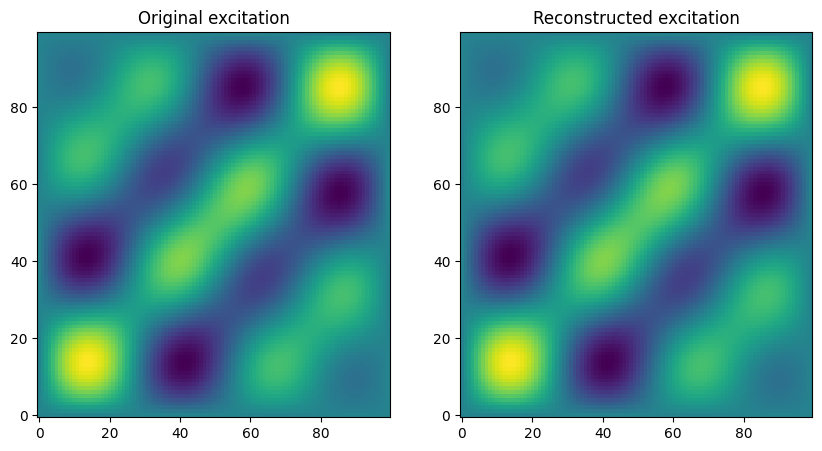

In [ ]:
length_x = 1.08
length_y = 0.8
n_max_modes_x = 25
n_max_modes_y = 25
n_gridpoints_x = 100
n_gridpoints_y = 100

x = np.linspace(0, length_x, n_gridpoints_x)
y = np.linspace(0, length_y, n_gridpoints_y)

wnx, wny = plate_wavenumbers(
    n_max_modes_x,
    n_max_modes_y,
    length_x,
    length_y,
)
K = plate_eigenfunctions(wnx, wny, x, y)

g = 0.5 * K[2, 2] + 0.5 * K[3, 3]

bar_g = forward_STL_2d(K, g, x, y, use_simpson=True)
g_reconstructed = inverse_STL_2d(K, bar_g, length_x, length_y)

assert np.allclose(g, g_reconstructed, atol=1e-2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(g, origin="lower", aspect="auto")
ax[0].set_title("Original excitation")
ax[1].imshow(g_reconstructed, origin="lower", aspect="auto")
ax[1].set_title("Reconstructed excitation")

In [ ]:
# | export


def forward_STL_drumhead(
    K: np.ndarray,  # (n_modes_r, n_modes_theta, n_gridpoints_r, n_gridpoints_theta)
    u: np.ndarray,  # (n_gridpoints_x, n_gridpoints_y, n_samples) or (n_gridpoints_x, n_gridpoints_y)
    r: np.ndarray,  # radial grid
    theta: np.ndarray,  # angular grid
    use_simpson: bool = False,
) -> np.ndarray:
    """
    Compute the forward STL transform. The integration is done using the trapezoidal rule or Simpson's rule.

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes_r, n_modes_theta, n_gridpoints_r, n_gridpoints_theta)
    u: np.ndarray
        The input signal. Shape (n_gridpoints_r, n_gridpoints_theta, n_samples) or (n_gridpoints_r, n_gridpoints_theta)
    dr: float
        The grid spacing of the sampled membrane.
    dtheta: float
        The grid spacing of the sampled membrane.

    Returns:
    --------
    np.ndarray
        The transformed signal. Shape (n_modes_r, n_modes_theta, n_samples) or (n_modes_r, n_modes_theta)
    """
    if u.ndim == 2:
        u = u[..., None]

    r_grid, _ = np.meshgrid(r, theta, indexing="ij")

    if use_simpson:
        max_n, max_m, _, _ = K.shape
        _, _, n_samples = u.shape

        transformed_signal = np.zeros((max_n, max_m, n_samples))

        for n in range(max_n):
            for m in range(max_m):
                for sample in range(n_samples):
                    integrand = (
                        u[..., sample] * K[n, m] * r_grid
                    )  # notice the r_grid (Jacobian determinant)
                    transformed_signal[n, m] = dblintegral(
                        integrand, x=r, y=theta, method="trapezoid"
                    )

    else:
        # integrand has shape (n_modes_r, n_modes_theta, n_gridpoints_r, n_gridpoints_theta)
        integrand = u[..., None].transpose(2, 3, 0, 1) * K * r_grid

        integral_y = trapezoid(integrand, x=theta, axis=-1)
        transformed_signal = trapezoid(integral_y, x=r, axis=-1)

    return (
        transformed_signal.squeeze()
        if transformed_signal.shape[-1] == 1
        else transformed_signal
    )


def inverse_STL_drumhead(
    K_inv: np.ndarray,  # (n_modes_x, n_modes_y, n_gridpoints_x, n_gridpoints_y)
    u_bar: np.ndarray,  # (n_modes_x, n_modes_y, n_samples) or (n_modes_x, n_modes_y)
) -> np.ndarray:
    """
    Compute the inverse STL transform using the formula of Rabenstein et al. (2000).

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u_bar: np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    length: float
        The length of the string.

    Returns:
    --------
    np.ndarray
        The reconstructed signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    """
    if u_bar.ndim == 2:
        u_bar = u_bar[
            ..., None
        ]  # Convert to (n_modes_x, n_modes_y, 1) if input is (n_modes_x, n_modes_y)

    reconstructed_signal = einsum("n m x y, n m s -> x y s", K_inv, u_bar)
    return (
        reconstructed_signal.squeeze() if u_bar.shape[-1] == 1 else reconstructed_signal
    )

-0.4320502477222054 0.43401550352665574
-0.4320519880367027 0.4340172517572766


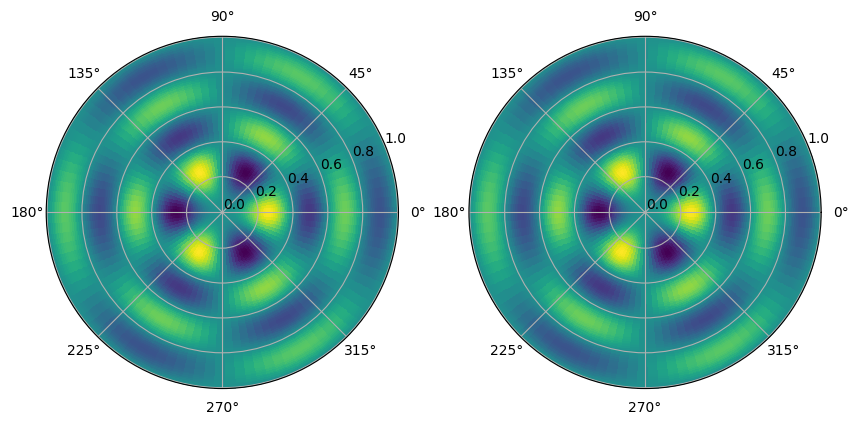

In [ ]:
# Example usage
n_max_modes = 10
m_max_modes = 10
radius = 1.0
n_gridpoints_r = 100
n_gridpoints_theta = 100

wavenumbers = drumhead_wavenumbers(n_max_modes, m_max_modes, radius)
eigenvalues = drumhead_eigenvalues(wavenumbers)
r = np.linspace(0, radius, n_gridpoints_r)
theta = np.linspace(0, 2 * np.pi, n_gridpoints_theta)
K_fwd, K_inv, K_N = drumhead_eigenfunctions(wavenumbers, r, theta)

assert np.allclose(
    K_fwd.shape, (n_max_modes, m_max_modes, n_gridpoints_r, n_gridpoints_theta)
)  # Should be (10, 10, 100, 100)
assert np.allclose(
    K_inv.shape, (n_max_modes, m_max_modes, n_gridpoints_r, n_gridpoints_theta)
)  # Should be (10, 10, 100, 100)

# Create an example g array to test the transforms
g = K_fwd[3, 3]

bar_g = forward_STL_drumhead(K_fwd, g, r, theta, use_simpson=False)
g_reconstructed = inverse_STL_drumhead(K_inv, bar_g)

# Verify if g can be reconstructed
assert np.allclose(g, g_reconstructed, atol=1e-2)
print(g.min(), g.max())
print(g_reconstructed.min(), g_reconstructed.max())

# Plot using pcolormesh
fig, ax = plt.subplots(
    1,
    2,
    subplot_kw={"projection": "polar"},
    figsize=(10, 5),
)
c = ax[0].pcolormesh(theta, r, g, shading="auto", cmap="viridis")
c = ax[1].pcolormesh(theta, r, g_reconstructed, shading="auto", cmap="viridis")

In [ ]:
# | export


def damping_term(
    params: PhysicalParameters,
    lambda_mu: jnp.ndarray,
):
    return (params.d1 + params.d3 * lambda_mu) / params.density


def damping_term_simple(
    lambda_mu: jnp.ndarray,
    factor: float = 1e-3,
):
    return factor * lambda_mu


def stiffness_term(
    params: PhysicalParameters,
    lambda_mu: jnp.ndarray,
):
    omega_mu = params.bending_stiffness * lambda_mu**2 + params.Ts0 * lambda_mu
    omega_mu = omega_mu / params.density
    return omega_mu

In [ ]:
# | export


def eigenvalues_from_pde(
    pars: PhysicalParameters,
    lambda_mu: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the positive imaginary side of the eigenvalues of the
    continuous-time system from the PDE parameters.

    Parameters
    ----------
    pars : PhysicalParameters
        The physical parameters of the system.
    lambda_mu : jnp.ndarray
        The eigenvalues of the decompostion of the Laplacian operator.

    Returns
    -------
    np.ndarray
        The eigenvalues of the continuous-time system.
    """

    gamma_mu = damping_term(pars, lambda_mu) / 2
    omega_mu_squared = stiffness_term(pars, lambda_mu)
    omega_mu_damped = np.sqrt(omega_mu_squared - gamma_mu**2)

    return -gamma_mu + 1j * omega_mu_damped

Some example use. Note that this is just a preview of how all the modes sound when excited at once. In a real setting they must be weighted with the eigenfunctions and the initial conditions or modal excitation.

In [ ]:
n_max_modes = 30
sr = 44100
dt = 1 / sr
final_time = 1.0
n_samples = int(final_time / dt)
p_params = StringParameters()
lambda_mu = string_eigenvalues(n_max_modes, p_params.length)
eigvals = eigenvalues_from_pde(p_params, lambda_mu)

eigvals_d = np.exp(eigvals * dt)
states = np.vander(eigvals_d, n_samples, increasing=True).real
display(Audio(states.sum(0), rate=sr))

In [ ]:
sr = 44100
dt = 1 / sr
n_modes_x = 8
n_modes_y = 8
n_modes = n_modes_x * n_modes_y
final_time = 6.0
n_samples = int(final_time / dt)

p_params = PlateParameters()
wnx, wny = plate_wavenumbers(
    n_max_modes_x,
    n_max_modes_y,
    p_params.l1,
    p_params.l2,
)
lambda_mu = plate_eigenvalues(wnx, wny)
lambda_mu = np.sort(lambda_mu.reshape(-1))[:n_modes]
eigvals = eigenvalues_from_pde(p_params, lambda_mu)
eigvals_d = np.exp(eigvals * dt)
states = np.vander(eigvals_d, n_samples, increasing=True).real

display(Audio(states.sum(0), rate=sr))

In [ ]:
sr = 44100
dt = 1 / sr
n_modes_x = 8
n_modes_y = 8
n_modes = n_modes_x * n_modes_y
final_time = 2.0
n_samples = int(final_time / dt)
p_params = CircularDrumHeadParameters.avanzini()

wn = drumhead_wavenumbers(n_max_modes_x, n_max_modes_y, p_params.r0)
lambda_mu = np.sort(drumhead_eigenvalues(wn).reshape(-1))[:n_modes]
eigvals = eigenvalues_from_pde(p_params, lambda_mu)
eigvals_d = np.exp(eigvals * dt)
states = np.vander(eigvals_d, n_samples, increasing=True).real

display(Audio(states[0], rate=sr))

In [ ]:
# | export


def sample_parallel_tf(
    num: np.ndarray,  # (n_modes,)
    den: np.ndarray,  # (n_modes,)
    dt: float,
    method: str = "impulse",
):
    """
    Sample multiple transfer functions.

    Parameters
    ----------
    num : np.ndarray
        The numerator of the transfer function.
    den : np.ndarray
        The denominator of the transfer function.

    Returns
    -------
    num_d : np.ndarray
        The numerator of the discrete-time transfer function.
    den_d : np.ndarray
        The denominator of the discrete-time transfer function.
    """

    def sample(n, d):
        b, a, _ = cont2discrete((n, d), dt, method=method)
        return b.flatten(), a.flatten()

    b, a = zip(*[sample(n, d) for n, d in zip(num, den)])

    return np.array(b), np.array(a)

In [ ]:
# | export


def tf_initial_conditions_continuous_2(
    D: float,
    density: float,
    d1: float,
    d3: float,
    Ts0: float,
    lambda_mu: jnp.array,
) -> tuple[jnp.array, jnp.array]:
    """
    Conpute the continuous-time initial condition transfer function.
    This is an alternative to the function `tf_initial_conditions_continuous`
    that eigenvalues of the PDE as input.

    Parameters
    ----------

    D : float
        The bending stiffness of the string or plate.
    density : float
        The area or surface density of the string or plate.
    d1 : float
        The linear damping coefficient, or frequency-independent damping.
    d3 : float
        The cubic damping coefficient, or frequency-dependent damping.
    Ts0 : float
        The initial tension of the string or plate.
    lambda_mu : jnp.array
        The eigenvalues from the decomposition of the Laplacian operator.

    Returns
    -------
    tuple[jnp.array, jnp.array]
        The numerator and denominator of the transfer function.
    """

    sigma_mu = (d1 + d3 * lambda_mu) / density

    omega_mu_squared = D * lambda_mu**2 + Ts0 * lambda_mu
    omega_mu_squared = omega_mu_squared / density

    a1 = sigma_mu
    a2 = omega_mu_squared
    ones = jnp.ones(lambda_mu.shape[0])

    # assemble the numerator and denominator for the transfer function
    # starting with highest order term
    b = jnp.stack([ones, a1], axis=-1)
    a = jnp.stack([ones, a1, a2], axis=-1)

    return (b, a)

In [ ]:
# | export


def tf_excitation_continuous(
    eigenvalues: np.ndarray,
    density: float,  # surface or area density
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the continuous excitation transfer function.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The surface density of a membrane (rho * h) or area density of a string (rho * A)
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    sigma_mu = -eigenvalues.real
    omega_mu = eigenvalues.imag

    a1 = sigma_mu * 2
    a2 = sigma_mu**2 + omega_mu**2

    ones = np.ones_like(sigma_mu)
    b = ones / density
    a = np.stack([ones, a1, a2], axis=-1)
    return b, a


def tf_excitation_discrete(
    eigenvalues: np.ndarray,
    density: float,  # surface or area density
    dt: float,  # time step
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the discrete-time excitation transfer function of a system.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The mass density of the system.
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    b, a = tf_excitation_continuous(eigenvalues, density)

    # Discretize the system
    tf_d = sample_parallel_tf(b, a, dt)

    return tf_d

In [ ]:
# | export


def tf_initial_conditions_continuous(
    eigenvalues: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the continuos "initial-conditions" transfer function from the eigenvalues of the system.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The mass density of the system.
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    sigma_mu = -eigenvalues.real
    omega_mu = eigenvalues.imag

    a1 = sigma_mu * 2
    a2 = sigma_mu**2 + omega_mu**2

    ones = np.ones_like(sigma_mu)
    b1 = a1

    b = np.stack([ones, b1], axis=-1)
    a = np.stack([ones, a1, a2], axis=-1)

    return (b, a)


def tf_initial_conditions_discrete(
    eigenvalues: np.ndarray,
    dt: float,  # time step
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the discrete-time initial conditions transfer function of a system.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The mass density of the system.
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    b, a = tf_initial_conditions_continuous(eigenvalues)

    # Discretize the system
    tf_d = sample_parallel_tf(b, a, dt)

    return tf_d

In [ ]:
# | test

b, a = tf_excitation_discrete(eigvals, p_params.density, dt)
b_ic, a_ic = tf_initial_conditions_discrete(eigvals, dt)

# manual discretization
eigenvalues_d = np.exp(eigvals * dt)

# for the excitation tf
b1 = (
    np.exp(eigvals.real * dt)
    * np.sin(eigvals.imag * dt)
    / eigvals.imag
    / p_params.density
)

# for the initial conditions tf
# here we ignore initial velocity
r = np.exp(eigvals.real * dt)
b1_ic = r * np.sin(eigvals.imag * dt) / eigvals.imag * -eigvals.real - r * np.cos(
    eigvals.imag * dt
)

a1 = -2 * np.exp(eigvals.real * dt) * np.cos(eigvals.imag * dt)
a2 = np.exp(2 * eigvals.real * dt)
b_manual = np.stack([np.zeros_like(b1), b1, np.zeros_like(b1)], axis=-1) * dt
a_manual = np.stack([np.ones_like(a1), a1, a2], axis=-1)

b_ic_manual = np.stack([np.ones_like(b1_ic), b1_ic], axis=-1) * dt

print(b[0])
print(b_manual[0])
print(b_ic[0] * sr)
print(b_ic_manual[0] * sr)
assert np.allclose(b[:, 1], b_manual[:, 1])
assert np.allclose(a, a_manual)
assert np.allclose(b_ic[:, :2], b_ic_manual[:, :2])

[0.00000000e+00 1.90416682e-09 1.11022302e-16]
[0.00000000e+00 1.90416703e-09 0.00000000e+00]
[ 1.00000000e+00 -9.99682425e-01  2.93765012e-11]
[ 1.         -0.99968243]
